In [ ]:
%matplotlib inline
%load_ext tensorboard
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Input,BatchNormalization,Flatten,MaxPooling2D,Activation,Dropout,concatenate,Softmax
from tensorflow.keras.models import Model,Sequential 
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/Assignment/dog-breed-identification.zip

In [ ]:
"""
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var colab = setInterval(ConnectButton,60000);
"""

In [ ]:
data = pd.read_csv("labels.csv")
data['path'] = data['id'].values+'.jpg'
data.head()

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
def plot_performance_metric(history):
  # Plot training & validation iou_score values
  plt.figure(figsize=(30, 5))
  plt.subplot(121)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(122)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
def finutune(model):
  x = Conv2D(256,(3,3),activation='relu',padding="valid")(model.output)
  x = Dropout(0.5)(x)

  x = tf.keras.layers.BatchNormalization()(x)

  x = Conv2D(128,(3,3),activation='relu',padding="valid")(x)
  x = Dropout(0.5)(x)

  x = tf.keras.layers.BatchNormalization()(x)

  x = Conv2D(64,(3,3),activation='relu',padding="valid")(x)
  x = Dropout(0.5)(x)

  fc1 = Dense(128, activation='relu')(x)
  fc2 = Dense(64, activation='relu')(fc1)
  flatten = Flatten()(fc2)
          
  output = Dense(120, activation='softmax')(flatten)

  model = Model(inputs = model.input,outputs = output)
  return model

#Inception Resnet V2

In [ ]:
datagen = ImageDataGenerator(
        rescale=1/255.,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rotation_range=30,
        brightness_range=[0.4,1.5],
        validation_split=0.1)

In [ ]:
train_generator = datagen.flow_from_dataframe(
dataframe=data,
directory="train/",
x_col="path",
y_col="breed",
subset="training",
batch_size=128,
shuffle=True,
class_mode="categorical",
target_size=(331, 331),
color_mode='rgb',
seed=42)

Found 9200 validated image filenames belonging to 120 classes.


In [ ]:
valid_generator=datagen.flow_from_dataframe(
dataframe=data,
directory="train/",
x_col="path",
y_col="breed",
subset="validation",
batch_size=128,
shuffle=True,
class_mode="categorical",
target_size=(331, 331),
color_mode='rgb',
seed=42)

Found 1022 validated image filenames belonging to 120 classes.


In [ ]:
inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(512, 512,3))
inception_resnet_v2.trainable = False

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
model_inception_resnet_v2 = finutune(inception_resnet_v2)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_inception_resnet_v2_history_log.csv", append=True,separator=",")

In [ ]:
checkpoint = ModelCheckpoint(root_dir+'model_inception_resnet_v2_weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
import datetime
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

In [ ]:
'''x = Conv2D(128,(3,3),activation='relu',padding="valid")(inception_resnet_v2.output)
x = Dropout(0.5)(x)

fc1 = Dense(128, activation='relu')(x)
fc2 = Dense(64, activation='relu')(fc1)
flatten = Flatten()(fc2)
        
output = Dense(120, activation='softmax')(flatten)

model_inception_resnet_v2 = Model(inputs = inception_resnet_v2.input,outputs = output)'''

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_inception_resnet_v2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model_inception_resnet_v2.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=50,
                      callbacks=[checkpoint, earlystopping, tensorboard_callback, csv_logger, reduce_lr])

Epoch 1/50
287/287 [==============================] - 719s 2s/step - loss: 4.7959 - accuracy: 0.0220 - val_loss: 4.4019 - val_accuracy: 0.1764 - lr: 1.0000e-04
Epoch 2/50
287/287 [==============================] - 685s 2s/step - loss: 3.5885 - accuracy: 0.1901 - val_loss: 1.9721 - val_accuracy: 0.5091 - lr: 1.0000e-04
Epoch 3/50
287/287 [==============================] - 664s 2s/step - loss: 1.5865 - accuracy: 0.5657 - val_loss: 0.9006 - val_accuracy: 0.7429 - lr: 1.0000e-04
Epoch 4/50
287/287 [==============================] - 682s 2s/step - loss: 0.9826 - accuracy: 0.7236 - val_loss: 0.6717 - val_accuracy: 0.8105 - lr: 1.0000e-04
Epoch 5/50
287/287 [==============================] - 694s 2s/step - loss: 0.7614 - accuracy: 0.7827 - val_loss: 0.6808 - val_accuracy: 0.8175 - lr: 1.0000e-04
Epoch 6/50
287/287 [==============================] - 688s 2s/step - loss: 0.6879 - accuracy: 0.8050 - val_loss: 0.6588 - val_accuracy: 0.8296 - lr: 1.0000e-04
Epoch 7/50
287/287 [====================

In [ ]:
history = pd.read_csv(root_dir+"model_inception_resnet_v2_history_log.csv")

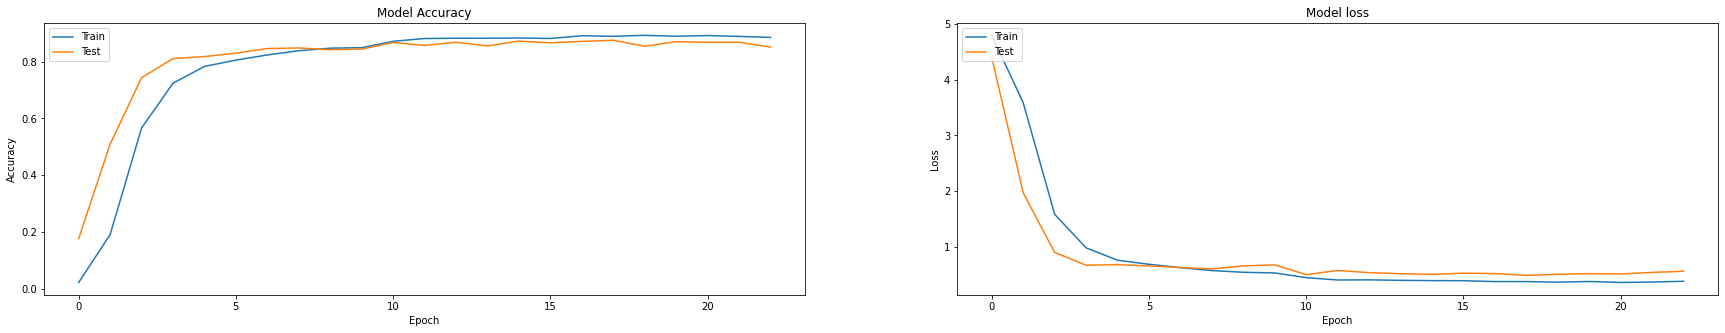

In [ ]:
plot_performance_metric(history)

#Nasnet Large

In [ ]:
nasnet = tf.keras.applications.NASNetLarge(include_top=False,weights="imagenet",input_shape=(331, 331, 3))
nasnet.trainable = False

In [ ]:
model_nasnet = finutune(nasnet)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

root_dir = '/content/drive/MyDrive/self_case_study/'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_nasnet_history_log.csv", append=True,separator=",")

checkpoint = ModelCheckpoint(root_dir+'model_nasnet_weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_nasnet.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model_nasnet.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=50,
                      callbacks=[checkpoint, earlystopping, csv_logger, reduce_lr])

Epoch 1/50
287/287 [==============================] - 400s 1s/step - loss: 4.6272 - accuracy: 0.0395 - val_loss: 3.8983 - val_accuracy: 0.4022 - lr: 1.0000e-04
Epoch 2/50
287/287 [==============================] - 383s 1s/step - loss: 3.1702 - accuracy: 0.2974 - val_loss: 1.5318 - val_accuracy: 0.7167 - lr: 1.0000e-04
Epoch 3/50
287/287 [==============================] - 378s 1s/step - loss: 1.3518 - accuracy: 0.6747 - val_loss: 0.7570 - val_accuracy: 0.8276 - lr: 1.0000e-04
Epoch 4/50
287/287 [==============================] - 385s 1s/step - loss: 0.8544 - accuracy: 0.7898 - val_loss: 0.6146 - val_accuracy: 0.8558 - lr: 1.0000e-04
Epoch 5/50
287/287 [==============================] - 378s 1s/step - loss: 0.6916 - accuracy: 0.8255 - val_loss: 0.5926 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 6/50
287/287 [==============================] - 370s 1s/step - loss: 0.6115 - accuracy: 0.8447 - val_loss: 0.5781 - val_accuracy: 0.8639 - lr: 1.0000e-04
Epoch 7/50
287/287 [====================

In [ ]:
history = pd.read_csv(root_dir+"model_nasnet_history_log.csv")

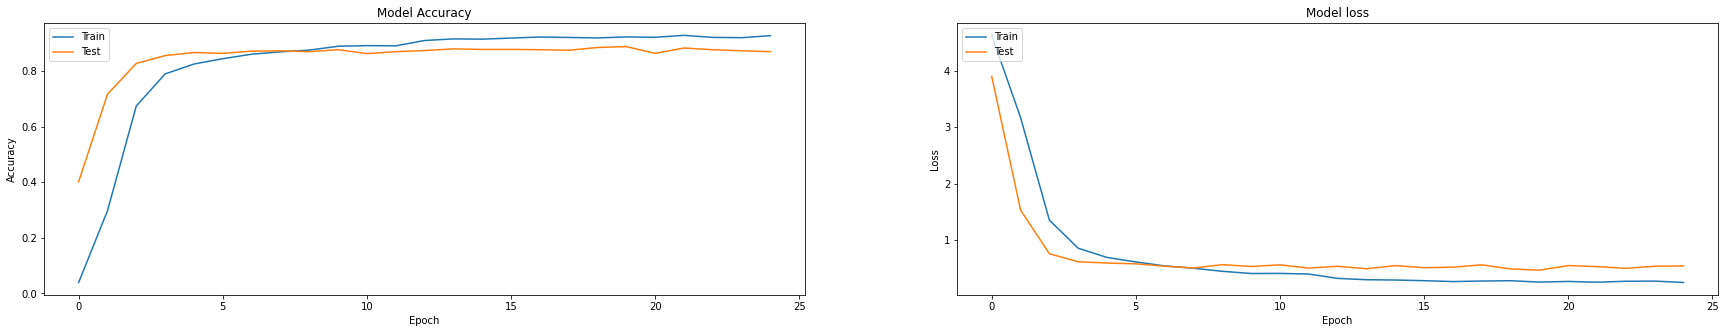

In [ ]:
plot_performance_metric(history)

#model InceptionV3

In [ ]:
model_InceptionV3 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512,3))
model_InceptionV3.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
model_InceptionV3 = finutune(model_InceptionV3)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

root_dir = '/content/drive/MyDrive/self_case_study/'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_InceptionV3_history_log.csv", append=True,separator=",")

checkpoint = ModelCheckpoint(root_dir+'model_InceptionV3_weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_InceptionV3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model_InceptionV3.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=50,
                      callbacks=[checkpoint, earlystopping, csv_logger, reduce_lr])

Epoch 1/50
287/287 [==============================] - 671s 2s/step - loss: 4.8543 - accuracy: 0.0142 - val_loss: 4.6396 - val_accuracy: 0.0857 - lr: 1.0000e-04
Epoch 2/50
287/287 [==============================] - 662s 2s/step - loss: 4.2466 - accuracy: 0.0781 - val_loss: 3.2271 - val_accuracy: 0.2127 - lr: 1.0000e-04
Epoch 3/50
287/287 [==============================] - 685s 2s/step - loss: 2.6719 - accuracy: 0.2852 - val_loss: 1.8040 - val_accuracy: 0.4647 - lr: 1.0000e-04
Epoch 4/50
287/287 [==============================] - 679s 2s/step - loss: 1.7534 - accuracy: 0.4835 - val_loss: 1.3529 - val_accuracy: 0.5655 - lr: 1.0000e-04
Epoch 5/50
287/287 [==============================] - 666s 2s/step - loss: 1.3512 - accuracy: 0.5969 - val_loss: 1.1300 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 6/50
287/287 [==============================] - 652s 2s/step - loss: 1.1023 - accuracy: 0.6650 - val_loss: 1.0047 - val_accuracy: 0.7167 - lr: 1.0000e-04
Epoch 7/50
287/287 [====================

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/'
history = pd.read_csv(root_dir+"model_InceptionV3_history_log.csv")

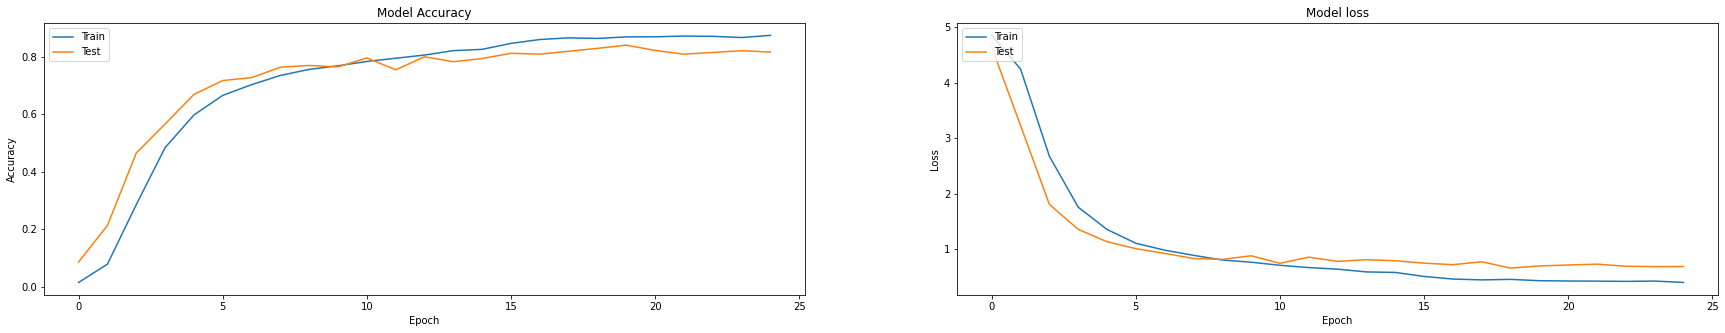

In [ ]:
plot_performance_metric(history)

#Model Xception

In [ ]:
model_Xception = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(512, 512,3))
model_Xception.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model_Xception = finutune(model_Xception)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

root_dir = '/content/drive/MyDrive/self_case_study/'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_Xception_history_log.csv", append=True,separator=",")

checkpoint = ModelCheckpoint(root_dir+'model_Xception_weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_Xception.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model_Xception.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=50,
                      callbacks=[checkpoint, earlystopping, csv_logger, reduce_lr])

Epoch 1/50
287/287 [==============================] - 725s 2s/step - loss: 4.7734 - accuracy: 0.0251 - val_loss: 4.1330 - val_accuracy: 0.1371 - lr: 1.0000e-04
Epoch 2/50
287/287 [==============================] - 693s 2s/step - loss: 3.2429 - accuracy: 0.2148 - val_loss: 1.9003 - val_accuracy: 0.4536 - lr: 1.0000e-04
Epoch 3/50
287/287 [==============================] - 696s 2s/step - loss: 1.7075 - accuracy: 0.4999 - val_loss: 1.1331 - val_accuracy: 0.6593 - lr: 1.0000e-04
Epoch 4/50
287/287 [==============================] - 726s 3s/step - loss: 1.1656 - accuracy: 0.6523 - val_loss: 0.9132 - val_accuracy: 0.7298 - lr: 1.0000e-04
Epoch 5/50
287/287 [==============================] - 718s 3s/step - loss: 0.9435 - accuracy: 0.7211 - val_loss: 0.8872 - val_accuracy: 0.7530 - lr: 1.0000e-04
Epoch 6/50
287/287 [==============================] - 691s 2s/step - loss: 0.8330 - accuracy: 0.7511 - val_loss: 0.8269 - val_accuracy: 0.7550 - lr: 1.0000e-04
Epoch 7/50
287/287 [====================

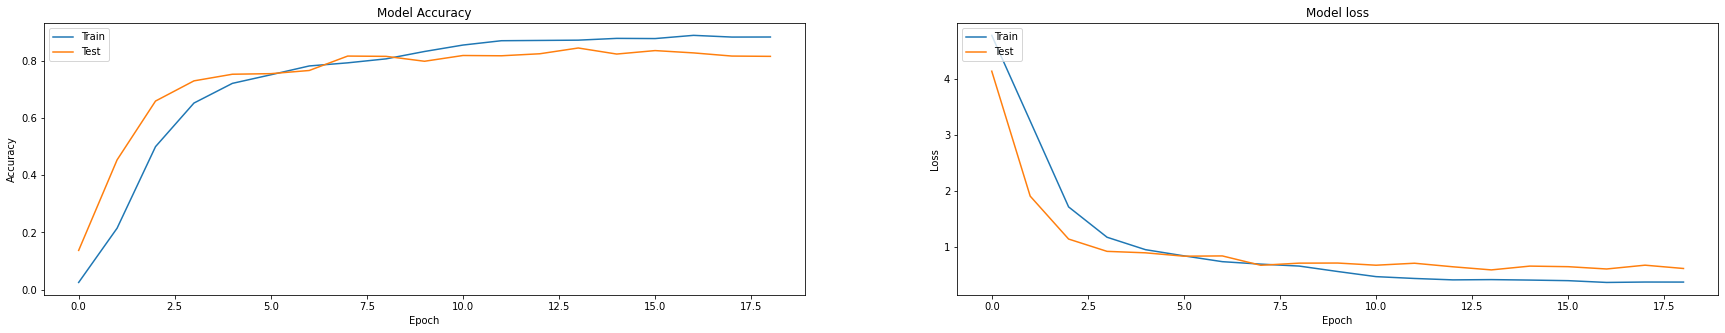

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/'
history = pd.read_csv(root_dir+"model_Xception_history_log.csv")
plot_performance_metric(history)

#Ensemble Model

In [ ]:
#credit:-https://www.kaggle.com/code/meherajhossain/dog-breed-transfer-learning-combining-4-backbones/notebook

IMG_HEIGHT = 331
IMG_WIDTH = 331
model_Xception = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
model_Xception.trainable = False

model_inception_v3 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
model_inception_v3.trainable = False

model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
model_inception_resnet_v2.trainable = False

model_nasnet = tf.keras.applications.nasnet.NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
model_nasnet.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x1 = model_Xception(inputs, training=False)
x1 = GlobalAveragePooling2D()(x1)

x2 = model_inception_v3(inputs, training=False)
x2 = GlobalAveragePooling2D()(x2)

x3 = model_inception_resnet_v2(inputs, training=False)
x3 = GlobalAveragePooling2D()(x3)

x5 = model_nasnet(inputs, training=False)
x5 = GlobalAveragePooling2D()(x5)

x = Concatenate()([x1, x2, x3, x5])
x = Dropout(.7)(x)
outputs = Dense(120, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

343621632/343610240 [==============================] - 10s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 11, 11, 2048  20861480    ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 inception_v3 (Functional)      (None, 9, 9, 2048)   21802784    ['input_5[0][0]']                
                          

None

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

root_dir = '/content/drive/MyDrive/self_case_study/debun/'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_ensemble_history_log.csv", append=True,separator=",")

checkpoint = ModelCheckpoint(root_dir+'model_ensemble_weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                      validation_data=valid_generator,
                      epochs=50,
                      callbacks=[checkpoint, earlystopping, csv_logger, reduce_lr])

Epoch 1/50
72/72 [==============================] - 678s 9s/step - loss: 1.1251 - accuracy: 0.7651 - val_loss: 0.3508 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 567s 8s/step - loss: 0.3075 - accuracy: 0.9060 - val_loss: 0.3624 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 584s 8s/step - loss: 0.2658 - accuracy: 0.9177 - val_loss: 0.3472 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 567s 8s/step - loss: 0.2482 - accuracy: 0.9200 - val_loss: 0.3696 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 582s 8s/step - loss: 0.2238 - accuracy: 0.9280 - val_loss: 0.3442 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 567s 8s/step - loss: 0.2049 - accuracy: 0.9317 - val_loss: 0.3399 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 566s 8s/step - loss: 0.1

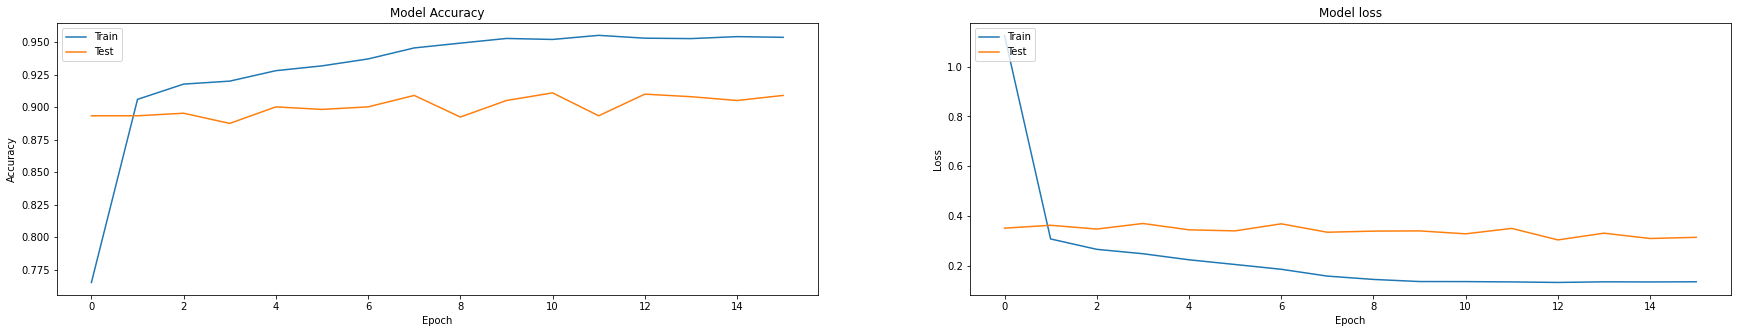

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/'
history = pd.read_csv(root_dir+"model_ensemble_history_log.csv")
plot_performance_metric(history)

In [ ]:
IMG_HEIGHT = 331
IMG_WIDTH = 331

model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
model_inception_resnet_v2.trainable = False

model_nasnet = tf.keras.applications.nasnet.NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
model_nasnet.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x1 = model_inception_resnet_v2(inputs, training=False)
x1 = GlobalAveragePooling2D()(x1)

x2 = model_nasnet(inputs, training=False)
x2 = GlobalAveragePooling2D()(x2)

x = Concatenate()([x1, x2])
x = Dropout(.7)(x)
outputs = Dense(120, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

343621632/343610240 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 9, 9, 1536)  54336736    ['input_3[0][0]']                
 l)                                                                                               
                                                                                                  
 NASNet (Functional)            (None, 11, 11, 4032  84916818    ['input_3[0][0]']                
                           

None

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

root_dir = '/content/drive/MyDrive/self_case_study/'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_ensemble_history_log2.csv", append=True,separator=",")

checkpoint = ModelCheckpoint(root_dir+'model_ensemble_weights2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                      validation_data=valid_generator,
                      epochs=50,
                      callbacks=[checkpoint, earlystopping, csv_logger, reduce_lr])

Epoch 1/50
72/72 [==============================] - 522s 7s/step - loss: 1.3692 - accuracy: 0.7490 - val_loss: 0.3504 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 462s 6s/step - loss: 0.3152 - accuracy: 0.9042 - val_loss: 0.3299 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 456s 6s/step - loss: 0.2853 - accuracy: 0.9136 - val_loss: 0.3168 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 443s 6s/step - loss: 0.2633 - accuracy: 0.9167 - val_loss: 0.3290 - val_accuracy: 0.9012 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 443s 6s/step - loss: 0.2420 - accuracy: 0.9213 - val_loss: 0.3291 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 442s 6s/step - loss: 0.2191 - accuracy: 0.9290 - val_loss: 0.3148 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 7/50
72/72 [==============================] - 452s 6s/step - loss:

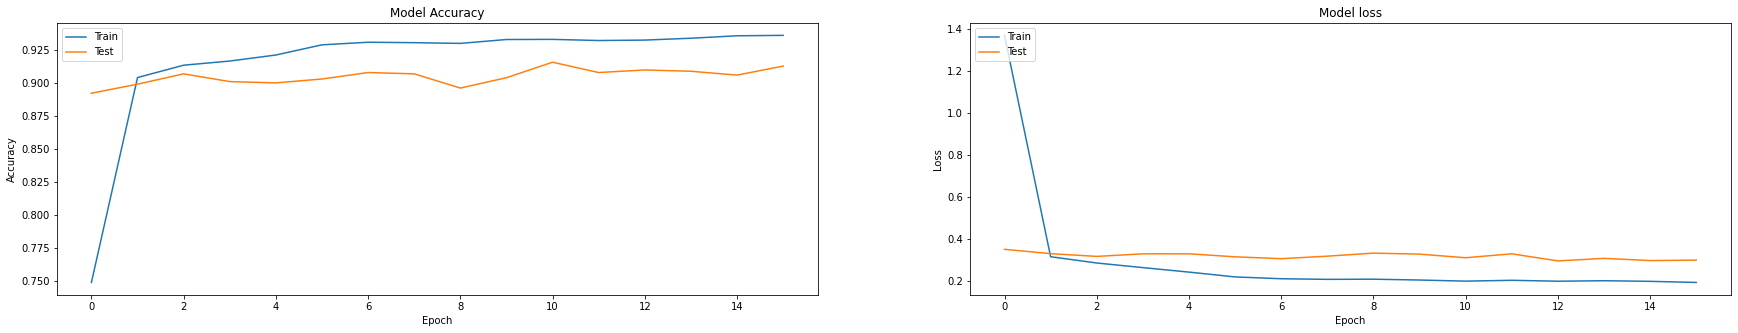

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/'
history = pd.read_csv(root_dir+"model_ensemble_history_log2.csv")
plot_performance_metric(history)

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/'
filepath=root_dir+'model_ensemble_weights2.h5'
model.load_weights(filepath)

In [ ]:
import shutil
os.makedirs("root/data/test/")
for i in tqdm(range(len(os.listdir('test')))):
    dir = os.listdir('test')[i]
    source = "test/"+dir

    # Destination path
    destination = "root/data/test/"
    shutil.copy(source, destination)

100%|██████████| 10357/10357 [01:05<00:00, 159.30it/s]


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        'root/data/',
        target_size=(331, 331),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 10357 images belonging to 1 classes.


In [ ]:
prediction = model.predict(test_data)

In [ ]:
id = []
for i in sorted(os.listdir('test')):
  id.append(i.split('.')[0])

In [ ]:
submission = pd.DataFrame(columns=['id']+sorted(np.unique(data['breed'])))

for i in tqdm(range(10357)):
  row = []
  row.append(id[i])
  for x in prediction[i]:
    row.append(x)
  submission.loc[len(submission.index)] = row

100%|██████████| 10357/10357 [01:47<00:00, 96.50it/s]


In [ ]:
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000006,0.000004,2.030777e-06,0.000001,0.000002,0.000002,1.597591e-06,0.000001,0.000003,...,0.000005,0.000002,0.000001,0.000002,6.728905e-07,0.000001,9.872916e-07,0.000001,3.407883e-06,0.000001
1,00102ee9d8eb90812350685311fe5890,0.000003,0.000006,4.276502e-06,0.000003,0.000020,0.000016,4.874784e-06,0.000006,0.000003,...,0.000004,0.000014,0.000006,0.000008,7.262964e-06,0.000003,1.978221e-05,0.000004,4.131025e-06,0.000006
2,0012a730dfa437f5f3613fb75efcd4ce,0.000002,0.000031,1.582063e-05,0.000006,0.000002,0.000009,1.799378e-06,0.000002,0.000013,...,0.000002,0.000003,0.000006,0.000017,6.358761e-05,0.000018,1.802823e-06,0.000006,4.108624e-06,0.000002
3,001510bc8570bbeee98c8d80c8a95ec1,0.000020,0.000009,9.082563e-07,0.000009,0.000008,0.000026,9.592111e-07,0.000004,0.000007,...,0.000004,0.000003,0.000002,0.000002,3.255347e-06,0.000002,1.401686e-06,0.000031,2.905903e-07,0.000003
4,001a5f3114548acdefa3d4da05474c2e,0.000821,0.000033,6.626959e-06,0.000012,0.000002,0.000017,4.771727e-06,0.000006,0.000016,...,0.000007,0.000011,0.000005,0.000006,3.811899e-06,0.000001,1.531241e-06,0.000015,3.263617e-06,0.000029


In [ ]:
submission.to_csv('model_ensemble_2.csv',index=False)

In [ ]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "Train Loss", "Test Loss", "Kaggle Score"])
  
# Add rows
myTable.add_row(["inception_resnet_v2", "0.3833", "0.5626", "0.308"])
myTable.add_row(["Nasnet", "0.2484", "0.5413", "0.321"])
myTable.add_row(["InceptionV3", "0.3952", "0.6826", "0.435"])
myTable.add_row(["Xception", "0.3643", "0.6072", "0.397"])
myTable.add_row(["Ensemble 4 Models", "0.1355", "0.3141", "0.192"])
myTable.add_row(["Ensemble 2 Models", "0.1928", "0.2990", "0.188"])
myTable.add_row(["Best Model with Stanford Data", "0.2296", "0.1881", "0.157"])

print(myTable)

+-------------------------------+------------+-----------+--------------+
|           Model Name          | Train Loss | Test Loss | Kaggle Score |
+-------------------------------+------------+-----------+--------------+
|      inception_resnet_v2      |   0.3833   |   0.5626  |    0.308     |
|             Nasnet            |   0.2484   |   0.5413  |    0.321     |
|          InceptionV3          |   0.3952   |   0.6826  |    0.435     |
|            Xception           |   0.3643   |   0.6072  |    0.397     |
|       Ensemble 4 Models       |   0.1355   |   0.3141  |    0.192     |
|       Ensemble 2 Models       |   0.1928   |   0.2990  |    0.188     |
| Best Model with Stanford Data |   0.2296   |   0.1881  |    0.157     |
+-------------------------------+------------+-----------+--------------+
